In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.utils import deaccent
from sklearn.metrics.pairwise import cosine_similarity

from aves.features.utils import normalize_rows
from aves.models.datafusion import DataFusionModel
from aves.features.utils import tfidf as aves_tfidf

sns.set(
    style="whitegrid", context="paper", font_scale=0.8, font="Fira Sans Extra Condensed"
)
mpl.rcParams["figure.dpi"] = 180

In [2]:
casen = pd.read_csv("../data/external/casen_2017/Casen2017.csv.gz")
comunas = casen["comuna"].unique().astype(int)
casen_2020 = pd.read_stata(
    "../data/external/casen_2020/Casen en Pandemia 2020_STATA.dta"
)
codes = pd.read_excel(
    "http://www.subdere.gov.cl/sites/default/files/documentos/CUT_2018_v04.xls"
)
codes

/home/aastroza/anaconda3/envs/bcc/lib/python3.8/site-packages/pandas/io/stata.py:1434: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


,Código Región,Nombre Región,Abreviatura Región,Código Provincia,Nombre Provincia,Código Comuna 2018,Nombre Comuna
0,1,Tarapacá,TPCA,11,Iquique,1101,Iquique
1,1,Tarapacá,TPCA,11,Iquique,1107,Alto Hospicio
2,1,Tarapacá,TPCA,14,Tamarugal,1401,Pozo Almonte
3,1,Tarapacá,TPCA,14,Tamarugal,1402,Camiña
4,1,Tarapacá,TPCA,14,Tamarugal,1403,Colchane
...,...,...,...,...,...,...,...
341,16,Ñuble,NUBLE,163,Punilla,16301,San Carlos
342,16,Ñuble,NUBLE,163,Punilla,16302,Coihueco
343,16,Ñuble,NUBLE,163,Punilla,16303,Ñiquén
344,16,Ñuble,NUBLE,163,Punilla,16304,San Fabián


# Elecciones Presidenciales

In [3]:
elecciones = pd.read_csv(
    "../data/external/presidenciales_2021/Servel_20211121_PRESIDENCIALES_CHILE.csv.gz",
    sep=";",
)
elecciones["votos_preliminar_string_strip"] = (
    elecciones["votos_preliminar_string"].str.strip().str.replace("^$", "0").astype(int)
)
elecciones.groupby("candidato")["votos_preliminar_string_strip"].sum()

candidato
EDUARDO ARTES BRICHETTI                                                                                  102493
FRANCO PARISI FERNANDEZ                                                                                  898407
GABRIEL BORIC FONT                                                                                      1796664
JOSE ANTONIO KAST RIST                                                                                  1954053
MARCO ENRIQUEZ-OMINAMI GUMUCIO                                                                           533657
SEBASTIAN SICHEL RAMIREZ                                                                                 894800
Total Sufragios Emitidos                                                                                7036860
Total Suma Calculada                                                                                    7036860
Votos Blancos                                                                                 

In [4]:
elecciones["comuna_nombre"] = elecciones["comuna_nombre"].str.strip()

In [6]:
elecciones.columns

Index(['eleccion_id', 'eleccion_nombre', 'region_id', 'region_nombre',
       'provincia_id', 'provincia_nombre', 'comuna_id', 'comuna_nombre',
       'circele_id', 'circele_nombre', 'local_id', 'local_nombre', 'mesa_id',
       'mesas_fusionadas', 'mesa_electores', 'mesa_numero', 'tipomesa',
       'mesa_descuadrada_preliminar', 'mesa_descuadrada_provisorio',
       'candidato', 'votos_preliminar_string', 'votos_provisorio_string',
       'nvoto', 'electo', 'codigo_colegio', 'nombre_colegio', 'sede_colegio',
       'cs_id', 'cs', 'distrito_id', 'distrito', 'lista', 'pacto',
       'partido_politico', 'votos_preliminar_string_strip'],
      dtype='object')

In [7]:
elecciones.iloc[10]

eleccion_id                                                                      4
eleccion_nombre                  Elección de Presidente 2021                   ...
region_id                                                                     3001
region_nombre                    DE TARAPACA                                   ...
provincia_id                                                                  4011
provincia_nombre                 IQUIQUE                                       ...
comuna_id                                                                     2501
comuna_nombre                                                              IQUIQUE
circele_id                                                                    7007
circele_nombre                   IQUIQUE                                       ...
local_id                                                                        12
local_nombre                     LICEO LUIS CRUZ MARTINEZ                      ...
mesa

In [8]:
turnout = (
    elecciones.groupby(["comuna_nombre", "candidato"])["votos_preliminar_string_strip"]
    .sum()
    .unstack()
)
turnout.columns = list(map(lambda x: x.strip(), turnout.columns))
turnout.columns

Index(['EDUARDO ARTES BRICHETTI', 'FRANCO PARISI FERNANDEZ',
       'GABRIEL BORIC FONT', 'JOSE ANTONIO KAST RIST',
       'MARCO ENRIQUEZ-OMINAMI GUMUCIO', 'SEBASTIAN SICHEL RAMIREZ',
       'Total Sufragios Emitidos', 'Total Suma Calculada', 'Votos Blancos',
       'Votos Nulos', 'YASNA PROVOSTE CAMPILLAY'],
      dtype='object')

In [9]:
codes["comuna_nombre"] = codes["Nombre Comuna"].str.upper().map(deaccent)
casen_comunas = casen.join(
    codes.set_index("Código Comuna 2018")["comuna_nombre"], on="comuna"
)
casen_2020["comuna_nombre"] = casen_2020["comuna"].str.upper().map(deaccent)
poblacion_comunas = (
    casen_2020[casen_2020["edad"] >= 17].groupby("comuna_nombre")["expr"].sum()
)

In [10]:
candidatos = [
    "EDUARDO ARTES BRICHETTI",
    "GABRIEL BORIC FONT",
    "JOSE ANTONIO KAST RIST",
    "MARCO ENRIQUEZ-OMINAMI GUMUCIO",
    "FRANCO PARISI FERNANDEZ",
    "YASNA PROVOSTE CAMPILLAY",
    "SEBASTIAN SICHEL RAMIREZ",
]
columnas_votos = candidatos + ["Votos Blancos", "Votos Nulos"]
total_votos = turnout[columnas_votos].sum(axis=1)
total_votos

comuna_nombre
ALGARROBO            8217
ALHUE                2517
ALTO BIOBIO          2008
ALTO DEL CARMEN      1964
ALTO HOSPICIO       24569
                    ...  
YUMBEL               8771
YUNGAY               6863
ZAPALLAR             5461
ÑIQUEN               4731
ÑUÑOA              123001
Length: 346, dtype: int64

In [11]:
abstencion = (poblacion_comunas - total_votos).rename("Abstención")
abstencion

comuna_nombre
ALGARROBO           4253.0
ALHUE               2827.0
ALTO BIOBIO         1769.0
ALTO DEL CARMEN     3344.0
ALTO HOSPICIO      71309.0
                    ...   
YUMBEL              6654.0
YUNGAY             10384.0
ZAPALLAR            1307.0
ÑIQUEN                 NaN
ÑUÑOA                  NaN
Name: Abstención, Length: 361, dtype: float64

In [12]:
turnout.join(abstencion, how="left")

,EDUARDO ARTES BRICHETTI,FRANCO PARISI FERNANDEZ,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,SEBASTIAN SICHEL RAMIREZ,Total Sufragios Emitidos,Total Suma Calculada,Votos Blancos,Votos Nulos,YASNA PROVOSTE CAMPILLAY,Abstención
comuna_nombre,,,,,,,,,,,,
ALGARROBO,90,568,1978,2877,472,1352,8217,8217,20,43,817,4253.0
ALHUE,31,357,636,467,151,320,2517,2517,16,19,520,2827.0
ALTO BIOBIO,40,255,377,502,119,155,1997,1997,80,81,399,1769.0
ALTO DEL CARMEN,11,365,260,265,56,87,1966,1966,14,15,891,3344.0
ALTO HOSPICIO,263,9884,3183,5860,1712,1212,24579,24579,70,173,2212,71309.0
...,...,...,...,...,...,...,...,...,...,...,...,...
YUMBEL,86,1361,1381,3275,472,794,8776,8776,71,89,1242,6654.0
YUNGAY,70,1351,1181,1930,388,681,6864,6864,54,60,1148,10384.0
ZAPALLAR,38,430,1069,1831,269,1311,5467,5467,15,31,467,1307.0


In [13]:
turnout = (
    turnout.reset_index()
    .assign(comuna_nombre=lambda x: x["comuna_nombre"].map(deaccent))
    .set_index("comuna_nombre")[columnas_votos]
)
turnout.join(abstencion, how="left")

,EDUARDO ARTES BRICHETTI,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,FRANCO PARISI FERNANDEZ,YASNA PROVOSTE CAMPILLAY,SEBASTIAN SICHEL RAMIREZ,Votos Blancos,Votos Nulos,Abstención
comuna_nombre,,,,,,,,,,
ALGARROBO,90,1978,2877,472,568,817,1352,20,43,4253.0
ALHUE,31,636,467,151,357,520,320,16,19,2827.0
ALTO BIOBIO,40,377,502,119,255,399,155,80,81,1769.0
ALTO DEL CARMEN,11,260,265,56,365,891,87,14,15,3344.0
ALTO HOSPICIO,263,3183,5860,1712,9884,2212,1212,70,173,71309.0
...,...,...,...,...,...,...,...,...,...,...
YUMBEL,86,1381,3275,472,1361,1242,794,71,89,6654.0
YUNGAY,70,1181,1930,388,1351,1148,681,54,60,10384.0
ZAPALLAR,38,1069,1831,269,430,467,1311,15,31,1307.0


In [14]:
total_votos = turnout.sum(axis=1)
abstencion = (poblacion_comunas - total_votos).rename("Abstención")
turnout.join(abstencion, how="left")

,EDUARDO ARTES BRICHETTI,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,FRANCO PARISI FERNANDEZ,YASNA PROVOSTE CAMPILLAY,SEBASTIAN SICHEL RAMIREZ,Votos Blancos,Votos Nulos,Abstención
comuna_nombre,,,,,,,,,,
ALGARROBO,90,1978,2877,472,568,817,1352,20,43,4253.0
ALHUE,31,636,467,151,357,520,320,16,19,2827.0
ALTO BIOBIO,40,377,502,119,255,399,155,80,81,1769.0
ALTO DEL CARMEN,11,260,265,56,365,891,87,14,15,3344.0
ALTO HOSPICIO,263,3183,5860,1712,9884,2212,1212,70,173,71309.0
...,...,...,...,...,...,...,...,...,...,...
YUMBEL,86,1381,3275,472,1361,1242,794,71,89,6654.0
YUNGAY,70,1181,1930,388,1351,1148,681,54,60,10384.0
ZAPALLAR,38,1069,1831,269,430,467,1311,15,31,1307.0


In [15]:
turnout = turnout.join(abstencion, how="left")[columnas_votos + ["Abstención"]]

In [16]:
turnout

,EDUARDO ARTES BRICHETTI,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,FRANCO PARISI FERNANDEZ,YASNA PROVOSTE CAMPILLAY,SEBASTIAN SICHEL RAMIREZ,Votos Blancos,Votos Nulos,Abstención
comuna_nombre,,,,,,,,,,
ALGARROBO,90,1978,2877,472,568,817,1352,20,43,4253.0
ALHUE,31,636,467,151,357,520,320,16,19,2827.0
ALTO BIOBIO,40,377,502,119,255,399,155,80,81,1769.0
ALTO DEL CARMEN,11,260,265,56,365,891,87,14,15,3344.0
ALTO HOSPICIO,263,3183,5860,1712,9884,2212,1212,70,173,71309.0
...,...,...,...,...,...,...,...,...,...,...
YUMBEL,86,1381,3275,472,1361,1242,794,71,89,6654.0
YUNGAY,70,1181,1930,388,1351,1148,681,54,60,10384.0
ZAPALLAR,38,1069,1831,269,430,467,1311,15,31,1307.0


# Plebiscito 2020

In [42]:
plebiscito = pd.read_excel(
    "../data/external/plebiscito_2020/Resultados Plebiscito Constitucion Politica 2020.xlsx",
    sheet_name='Chile',
    engine='openpyxl'
)
plebiscito.head()

,Nro. Región,Región,Provincia,Circ.Senatorial,Distrito,Comuna,Circ.Electoral,Local,Mesa,Tipo mesa,Mesas Fusionadas,Electores,Nro.voto,Opción Constitución Política,Votos TRICEL,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,1.0,DE TARAPACA,IQUIQUE,Circ. Senatorial 2,DISTRITO 2,ALTO HOSPICIO,ALTO HOSPICIO,ANEXO DE COLEGIO SAN ANTONIO DE MATILLA,18.0,M,18M,344.0,1.0,APRUEBO,139.0,NaN,NaN,NaN,NaN
1,1.0,DE TARAPACA,IQUIQUE,Circ. Senatorial 2,DISTRITO 2,ALTO HOSPICIO,ALTO HOSPICIO,ANEXO DE COLEGIO SAN ANTONIO DE MATILLA,18.0,M,18M,344.0,2.0,RECHAZO,34.0,NaN,NaN,NaN,NaN
2,1.0,DE TARAPACA,IQUIQUE,Circ. Senatorial 2,DISTRITO 2,ALTO HOSPICIO,ALTO HOSPICIO,ANEXO DE COLEGIO SAN ANTONIO DE MATILLA,18.0,M,18M,344.0,900.0,VOTOS NULOS,1.0,NaN,NaN,NaN,NaN
3,1.0,DE TARAPACA,IQUIQUE,Circ. Senatorial 2,DISTRITO 2,ALTO HOSPICIO,ALTO HOSPICIO,ANEXO DE COLEGIO SAN ANTONIO DE MATILLA,18.0,M,18M,344.0,901.0,VOTOS EN BLANCO,0.0,NaN,NaN,NaN,NaN
4,1.0,DE TARAPACA,IQUIQUE,Circ. Senatorial 2,DISTRITO 2,ALTO HOSPICIO,ALTO HOSPICIO,ANEXO DE COLEGIO SAN ANTONIO DE MATILLA,19.0,M,19M,343.0,1.0,APRUEBO,157.0,NaN,NaN,NaN,NaN


In [44]:
plebiscito.columns

Index(['Nro. Región', 'Región', 'Provincia', 'Circ.Senatorial', 'Distrito',
       'Comuna', 'Circ.Electoral', 'Local', 'Mesa', 'Tipo mesa',
       'Mesas Fusionadas', 'Electores', 'Nro.voto',
       'Opción Constitución Política', 'Votos TRICEL', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'],
      dtype='object')

In [45]:
plebiscito.columns = ['region_id', 'region_nombre', 'provincia_nombre', 'circsena_nombre', 'distrito_nombre',
       'comuna_nombre', 'circele_nombre', 'loca_nombre', 'mesa_id', 'tipomesa',
       'mesas_fusionadas', 'electo', 'nvoto',
       'opcion_constitucion', 'votos_tricel', 'aux1', 'aux2', 'aux3', 'aux4']

In [46]:
plebiscito["comuna_nombre"] = plebiscito["comuna_nombre"].str.strip()

In [47]:
plebiscito.iloc[0]

region_id                                                    1
region_nombre                                      DE TARAPACA
provincia_nombre                                       IQUIQUE
circsena_nombre                             Circ. Senatorial 2
distrito_nombre                                     DISTRITO 2
comuna_nombre                                    ALTO HOSPICIO
circele_nombre                                   ALTO HOSPICIO
loca_nombre            ANEXO DE COLEGIO SAN ANTONIO DE MATILLA
mesa_id                                                     18
tipomesa                                                     M
mesas_fusionadas                                           18M
electo                                                     344
nvoto                                                        1
opcion_constitucion                                    APRUEBO
votos_tricel                                               139
aux1                                                   

In [48]:
plebiscito.groupby("opcion_constitucion")["votos_tricel"].sum()

opcion_constitucion
APRUEBO            5874352.0
RECHAZO            1628958.0
TOTALES            7542952.0
VOTOS EN BLANCO      12313.0
VOTOS NULOS          27329.0
Name: votos_tricel, dtype: float64

In [49]:
turnout_plebiscito = (
    plebiscito.groupby(["comuna_nombre", "opcion_constitucion"])["votos_tricel"]
    .sum()
    .unstack()
)
turnout_plebiscito.columns = list(map(lambda x: x.strip(), turnout_plebiscito.columns))
turnout_plebiscito.columns

Index(['APRUEBO', 'RECHAZO', 'VOTOS EN BLANCO', 'VOTOS NULOS'], dtype='object')

In [50]:
turnout_plebiscito

,APRUEBO,RECHAZO,VOTOS EN BLANCO,VOTOS NULOS
comuna_nombre,,,,
ALGARROBO,4932.0,2118.0,13.0,23.0
ALHUE,2323.0,309.0,1.0,7.0
ALTO BIOBIO,1269.0,424.0,43.0,69.0
ALTO DEL CARMEN,1559.0,241.0,8.0,9.0
ALTO HOSPICIO,21589.0,4534.0,37.0,98.0
...,...,...,...,...
YUMBEL,5246.0,2149.0,25.0,56.0
YUNGAY,5262.0,1584.0,16.0,29.0
ZAPALLAR,3250.0,1643.0,3.0,13.0


In [51]:
constitucion = [
    "APRUEBO",
    "RECHAZO",
]
columnas_votos_plebiscito = constitucion + ["VOTOS EN BLANCO", "VOTOS NULOS"]
total_votos_plebiscito = turnout_plebiscito[columnas_votos_plebiscito].sum(axis=1)
total_votos_plebiscito

comuna_nombre
ALGARROBO            7086.0
ALHUE                2640.0
ALTO BIOBIO          1805.0
ALTO DEL CARMEN      1817.0
ALTO HOSPICIO       26258.0
                     ...   
YUMBEL               7476.0
YUNGAY               6891.0
ZAPALLAR             4909.0
ÑIQUEN               3259.0
ÑUÑOA              125508.0
Length: 346, dtype: float64

In [52]:
abstencion_plebiscito = (poblacion_comunas - total_votos_plebiscito).rename("Abstención")
abstencion_plebiscito

comuna_nombre
ALGARROBO           5384.0
ALHUE               2704.0
ALTO BIOBIO         1972.0
ALTO DEL CARMEN     3491.0
ALTO HOSPICIO      69620.0
                    ...   
YUMBEL              7949.0
YUNGAY             10356.0
ZAPALLAR            1859.0
ÑIQUEN                 NaN
ÑUÑOA                  NaN
Name: Abstención, Length: 361, dtype: float64

In [53]:
turnout_plebiscito.join(abstencion, how="left")

,APRUEBO,RECHAZO,VOTOS EN BLANCO,VOTOS NULOS,Abstención
comuna_nombre,,,,,
ALGARROBO,4932.0,2118.0,13.0,23.0,4253.0
ALHUE,2323.0,309.0,1.0,7.0,2827.0
ALTO BIOBIO,1269.0,424.0,43.0,69.0,1769.0
ALTO DEL CARMEN,1559.0,241.0,8.0,9.0,3344.0
ALTO HOSPICIO,21589.0,4534.0,37.0,98.0,71309.0
...,...,...,...,...,...
YUMBEL,5246.0,2149.0,25.0,56.0,6654.0
YUNGAY,5262.0,1584.0,16.0,29.0,10384.0
ZAPALLAR,3250.0,1643.0,3.0,13.0,1307.0


In [55]:
total_votos_plebiscito = turnout_plebiscito.sum(axis=1)
abstencion_plebiscito = (poblacion_comunas - total_votos_plebiscito).rename("Abstención")
turnout_plebiscito.join(abstencion_plebiscito, how="left")

,APRUEBO,RECHAZO,VOTOS EN BLANCO,VOTOS NULOS,Abstención
comuna_nombre,,,,,
ALGARROBO,4932.0,2118.0,13.0,23.0,5384.0
ALHUE,2323.0,309.0,1.0,7.0,2704.0
ALTO BIOBIO,1269.0,424.0,43.0,69.0,1972.0
ALTO DEL CARMEN,1559.0,241.0,8.0,9.0,3491.0
ALTO HOSPICIO,21589.0,4534.0,37.0,98.0,69620.0
...,...,...,...,...,...
YUMBEL,5246.0,2149.0,25.0,56.0,7949.0
YUNGAY,5262.0,1584.0,16.0,29.0,10356.0
ZAPALLAR,3250.0,1643.0,3.0,13.0,1859.0


In [56]:
turnout_plebiscito = turnout_plebiscito.join(abstencion_plebiscito, how="left")[columnas_votos_plebiscito + ["Abstención"]]

In [57]:
turnout_plebiscito

,APRUEBO,RECHAZO,VOTOS EN BLANCO,VOTOS NULOS,Abstención
comuna_nombre,,,,,
ALGARROBO,4932.0,2118.0,13.0,23.0,5384.0
ALHUE,2323.0,309.0,1.0,7.0,2704.0
ALTO BIOBIO,1269.0,424.0,43.0,69.0,1972.0
ALTO DEL CARMEN,1559.0,241.0,8.0,9.0,3491.0
ALTO HOSPICIO,21589.0,4534.0,37.0,98.0,69620.0
...,...,...,...,...,...
YUMBEL,5246.0,2149.0,25.0,56.0,7949.0
YUNGAY,5262.0,1584.0,16.0,29.0,10356.0
ZAPALLAR,3250.0,1643.0,3.0,13.0,1859.0


# Otros Datos

In [18]:
from glob import glob

programas = sorted(
    glob(
        "../data/external/programas-presidenciales-2021/programas-primera-vuelta/*.txt"
    )
)

stopwords = pd.read_csv(
    "https://raw.githubusercontent.com/stopwords-iso/stopwords-es/master/stopwords-es.txt",
    names=["word"],
)

from sklearn.feature_extraction.text import CountVectorizer
from aves.features.twokenize import tokenize

vectorizer = CountVectorizer(
    input="filename", tokenizer=tokenize, stop_words=list(stopwords["word"])
)
dtm = vectorizer.fit_transform(programas)

from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(sublinear_tf=True, norm="l2", smooth_idf=True)
weighted_dtm = tfidf.fit_transform(dtm)
weighted_dtm_df = pd.DataFrame(
    weighted_dtm.todense(), index=candidatos, columns=vectorizer.get_feature_names()
)


In [19]:
weighted_dtm_df = weighted_dtm_df[[c for c in weighted_dtm_df.columns if len(c) >= 3]]
weighted_dtm_df.loc["GABRIEL BORIC FONT"].sort_values(ascending=False)

lgbtiaq+            0.035946
ctci                0.034085
trabajaremos        0.032581
sexista             0.029603
descentralizada     0.028886
                      ...   
latinoamérica       0.000000
latinoamericano     0.000000
latinoamericanas    0.000000
latin               0.000000
!!!                 0.000000
Name: GABRIEL BORIC FONT, Length: 20450, dtype: float64

In [20]:
weighted_dtm_df_T = weighted_dtm_df.T

for c in turnout.columns:
    if not c in weighted_dtm_df_T.columns:
        weighted_dtm_df_T[c] = 0

weighted_dtm_df = weighted_dtm_df_T.T
weighted_dtm_df

,!!!,#20propuestas,#menstruaciónlibredeimpuestos,$/us$,$1.000.000.000,$1.006.211,$1.015,$1.100.000,$1.550,$1.565.108,...,óxidos,últimamente,única,únicamente,únicas,único,únicos,útil,útiles,−fonasa
EDUARDO ARTES BRICHETTI,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.041078,0.000000,0.000000,0.000000,0.000000
GABRIEL BORIC FONT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.008754,0.000000,0.006705,0.013437,0.000000,0.000000,0.009035,0.000000
JOSE ANTONIO KAST RIST,0.008233,0.000000,0.000000,0.008233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008233,0.008233,0.008208,0.005842,0.008587,0.007241,0.009891,0.010644,0.016309,0.008233
MARCO ENRIQUEZ-OMINAMI GUMUCIO,0.000000,0.000000,0.009964,0.000000,0.000000,0.000000,0.009964,0.009964,0.009964,0.000000,...,0.000000,0.000000,0.013943,0.007070,0.000000,0.014188,0.000000,0.006138,0.000000,0.000000
FRANCO PARISI FERNANDEZ,0.000000,0.000000,0.000000,0.000000,0.012566,0.012566,0.000000,0.000000,0.000000,0.012566,...,0.000000,0.000000,0.020801,0.021276,0.007741,0.014701,0.008916,0.013106,0.000000,0.000000
YASNA PROVOSTE CAMPILLAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.008615,0.000000,0.005324,0.008642,0.000000,0.009014,0.000000,0.000000
SEBASTIAN SICHEL RAMIREZ,0.000000,0.013041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.018249,0.000000,0.000000,0.016099,0.009253,0.000000,0.000000,0.000000
Votos Blancos,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Votos Nulos,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Abstención,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
comunas_x_ingreso = (
    casen_comunas.groupby(["comuna_nombre", "dautr"])["expr"]
    .sum()
    .unstack(fill_value=0)
)

comunas_x_drogas = (
    casen_comunas.groupby(["comuna_nombre", "v38b"])["expr"].sum().unstack(fill_value=0)
)
comunas_x_drogas.columns = ["Nunca", "Pocas veces", "Muchas veces", "Siempre", "N/A"]

comunas_index = turnout.join(comunas_x_ingreso, how="inner").index

casen_comunas["grupo_etareo"] = pd.cut(
    casen_comunas["edad"], bins=[-1, 17, 25, 35, 45, 55, 65, 75, 85, 95, 120]
)
comunas_x_edad = (
    casen_comunas.groupby(["comuna_nombre", "grupo_etareo"])["expr"]
    .sum()
    .unstack(fill_value=0)
)

column_map = {1: "prepaid", 2: "contract", 3: "prepaid_and_contract", 4: "no", 9: "n/a"}
comunas_x_moviles = casen_comunas.pivot_table(
    index="comuna_nombre", columns="r22", values="expr", aggfunc="sum"
).fillna(0)
comunas_x_moviles.columns = comunas_x_moviles.columns.map(lambda x: column_map[int(x)])

comunas_x_trabajo = (
    casen_2020.groupby(["comuna_nombre", "o15"])["expr"].sum().unstack(fill_value=0)
)

comunas_x_oficio = (
    casen_2020.groupby(["comuna_nombre", "oficio1_88"])["expr"]
    .sum()
    .unstack(fill_value=0)
)

comunas_x_origen = (
    casen_2020.groupby(["comuna_nombre", "r1b"])["expr"].sum().unstack(fill_value=0)
)

comunas_x_migrantes = (
    casen_2020.groupby(["comuna_nombre", "r1b_p_cod"])["expr"]
    .sum()
    .unstack(fill_value=0)
)

comunas_x_tipo_hogar = (
    casen_2020.groupby(["comuna_nombre", "tipohogar"])["expr"]
    .sum()
    .unstack(fill_value=0)
)

comunas_x_estado_civil = (
    casen_2020.groupby(["comuna_nombre", "ecivil"])["expr"]
    .sum()
    .unstack(fill_value=0)
    .drop("No sabe\\No responde", axis=1)
)

comunas_x_area = (
    casen_2020.groupby(["comuna_nombre", "area"])["expr"].sum().unstack(fill_value=0)
)

comunas_x_retiro = (
    casen_2020.groupby(["comuna_nombre", "o32b"])["expr"].sum().unstack(fill_value=0)
)

comunas_x_edad = (
    casen_2020[casen_2020["edad"] >= 18]
    .assign(
        grupo_etareo=lambda x: pd.cut(
            x["edad"], bins=[17, 25, 35, 45, 55, 65, 75, 85, 95, 120]
        )
    )
    .groupby(["comuna_nombre", "grupo_etareo"])["expr"]
    .sum()
    .unstack(fill_value=0)
)

comunas_x_internet = (
    casen_comunas[casen_comunas["edad"] >= 18]
    .groupby(["comuna_nombre", "r21a"])["expr"]
    .sum()
    .unstack(fill_value=0)
)
comunas_x_internet.columns = [
    "Usó redes sociales/Internet para informarse",
    "No usa redes sociales/Internet para informarse",
    "N/A",
]

delitos = pd.read_csv(
    "../data/external/delitos_cl_2016/Frec_CASOS_POLICIALES_ANUAL_2016.csv"
)

comunas_x_delitos = (
    delitos[delitos["UN_ADMIN"] == "COMUNA"]
    .assign(
        comuna_nombre=lambda x: x["UNIDAD TERRITORIAL"]
        .str.replace("La Calera", "Calera")
        .str.upper()
        .map(deaccent)
    )
    .set_index("comuna_nombre")
    .drop(["ORDEN", "UN_ADMIN", "REGION", "UNIDAD TERRITORIAL"], axis=1)
)



In [74]:
model_nodes = {
    "candidatos": 12,
    "constitucion": 6,
    "comunas": 64,
    "grupo_etareo": 6,
    "programa": 24,
    "ingreso": 6,
    "celular": 2,
    "oficio": 8,
    "trabajo": 8,
    "retiro": 2,
    "origen": 2,
    "migrantes": 8,
    "hogar": 4,
    "narcotráfico": 3,
    "estado_civil": 4,
    "area": 2,
    "delincuencia": 4,
    "internet_inf": 2,
}

model_relations = {
    ("candidatos", "comunas"): [turnout.fillna(0).pipe(aves_tfidf).loc[comunas_index].T],
    ("constitucion", "comunas"): [turnout_plebiscito.fillna(0).pipe(aves_tfidf).loc[comunas_index].T],
    ("comunas", "constitucion"): [turnout_plebiscito.fillna(0).pipe(aves_tfidf).loc[comunas_index]],
    ("comunas", "grupo_etareo"): [
        comunas_x_edad.pipe(normalize_rows).loc[comunas_index]
    ],
    ("comunas", "ingreso"): [comunas_x_ingreso.pipe(normalize_rows).loc[comunas_index]],
    ("programa", "candidatos"): [weighted_dtm_df.T],
    ("comunas", "celular"): [comunas_x_moviles.pipe(normalize_rows).loc[comunas_index]],
    ("comunas", "oficio"): [comunas_x_oficio.pipe(normalize_rows).loc[comunas_index]],
    ("comunas", "trabajo"): [comunas_x_trabajo.pipe(normalize_rows).loc[comunas_index]],
    ("comunas", "retiro"): [comunas_x_retiro.pipe(normalize_rows).loc[comunas_index]],
    ("comunas", "origen"): [comunas_x_origen.pipe(normalize_rows).loc[comunas_index]],
    ("comunas", "migrantes"): [
        comunas_x_migrantes.pipe(normalize_rows).loc[comunas_index]
    ],
    ("comunas", "hogar"): [
        comunas_x_tipo_hogar.pipe(normalize_rows).loc[comunas_index]
    ],
    ("comunas", "narcotráfico"): [
        comunas_x_drogas.pipe(normalize_rows).loc[comunas_index]
    ],
    ("comunas", "estado_civil"): [
        comunas_x_estado_civil.pipe(normalize_rows).loc[comunas_index]
    ],
    ("comunas", "area"): [comunas_x_area.pipe(normalize_rows).loc[comunas_index]],
    ("comunas", "delincuencia"): [
        comunas_x_delitos.pipe(normalize_rows).loc[comunas_index]
    ],
    ("comunas", "internet_inf"): [
        comunas_x_internet.pipe(normalize_rows).loc[comunas_index]
    ],
}

model = DataFusionModel(nodes=model_nodes, relations=model_relations)
model.fit()

{'candidatos': ObjectType("candidatos"), 'constitucion': ObjectType("constitucion"), 'comunas': ObjectType("comunas"), 'grupo_etareo': ObjectType("grupo_etareo"), 'programa': ObjectType("programa"), 'ingreso': ObjectType("ingreso"), 'celular': ObjectType("celular"), 'oficio': ObjectType("oficio"), 'trabajo': ObjectType("trabajo"), 'retiro': ObjectType("retiro"), 'origen': ObjectType("origen"), 'migrantes': ObjectType("migrantes"), 'hogar': ObjectType("hogar"), 'narcotráfico': ObjectType("narcotráfico"), 'estado_civil': ObjectType("estado_civil"), 'area': ObjectType("area"), 'delincuencia': ObjectType("delincuencia"), 'internet_inf': ObjectType("internet_inf")}
[Relation(ObjectType("candidatos") → ObjectType("comunas")), Relation(ObjectType("constitucion") → ObjectType("comunas")), Relation(ObjectType("comunas") → ObjectType("constitucion")), Relation(ObjectType("comunas") → ObjectType("grupo_etareo")), Relation(ObjectType("comunas") → ObjectType("ingreso")), Relation(ObjectType("progra

<class 'skfusion.fusion.base.fusion_graph.ObjectType'> candidatos False (10, 12)
Relation(candidatos → comunas)
Relation(comunas → grupo_etareo)


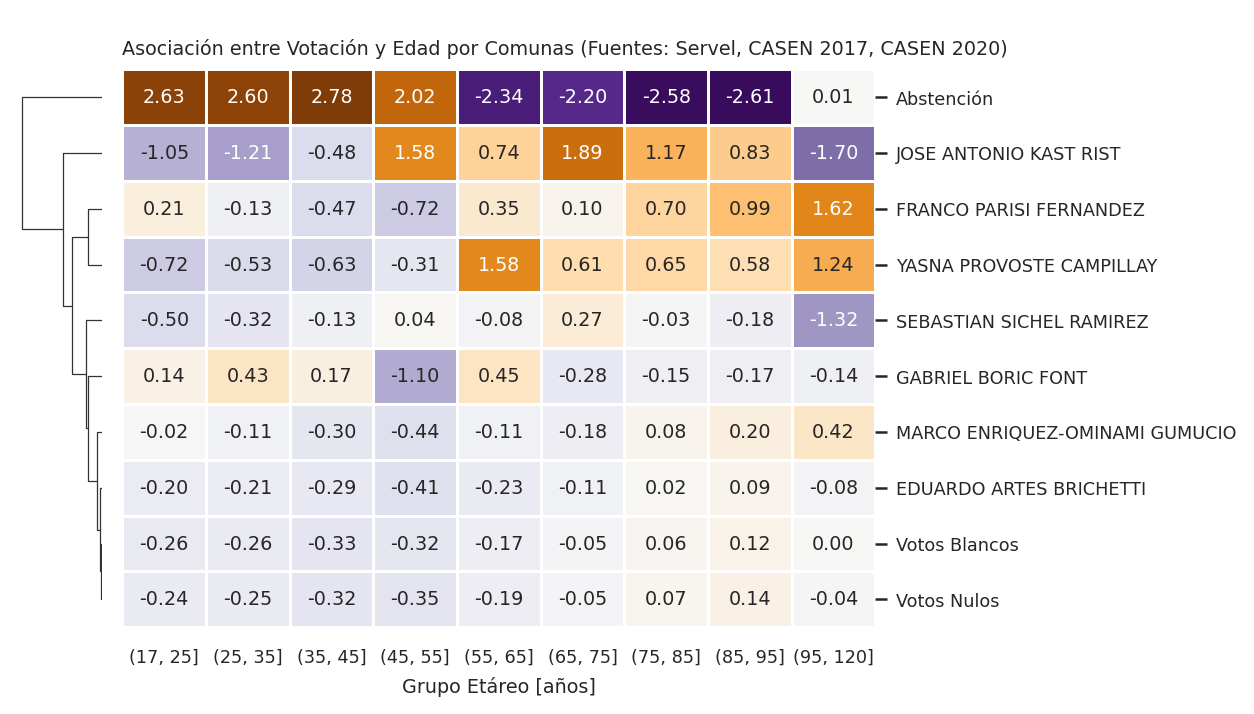

In [67]:
from aves.features.utils import standardize_columns, standardize_rows

grid = sns.clustermap(
    model.relation_profiles("candidatos", "grupo_etareo")[0][1].pipe(
        standardize_columns
    ),
    col_cluster=False,
    figsize=(7, 4),
    annot=True,
    fmt=".2f",
    linewidth=0.5,
    dendrogram_ratio=[0.1, 0.0],
    method="ward",
    center=0,
    cmap="PuOr_r",
)

grid.ax_cbar.set_visible(False)
grid.ax_heatmap

grid.ax_heatmap.set_ylabel("")
grid.ax_heatmap.set_xlabel("Grupo Etáreo [años]")
grid.ax_heatmap.set_title(
    "Asociación entre Votación y Edad por Comunas (Fuentes: Servel, CASEN 2017, CASEN 2020)",
    loc="left",
)

grid.fig.tight_layout()

<class 'skfusion.fusion.base.fusion_graph.ObjectType'> constitucion False (5, 4)
Relation(constitucion → comunas)
Relation(comunas → grupo_etareo)


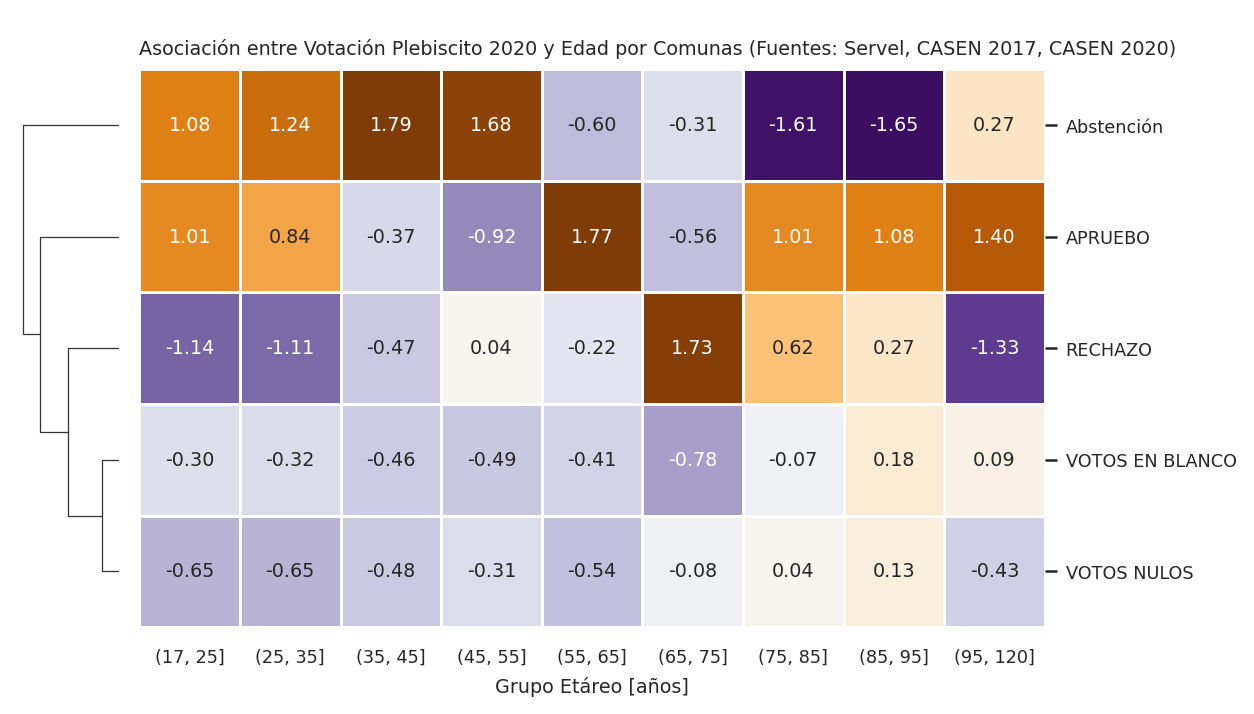

In [59]:
from aves.features.utils import standardize_columns, standardize_rows

grid = sns.clustermap(
    model.relation_profiles("constitucion", "grupo_etareo")[0][1].pipe(
        standardize_columns
    ),
    col_cluster=False,
    figsize=(7, 4),
    annot=True,
    fmt=".2f",
    linewidth=0.5,
    dendrogram_ratio=[0.1, 0.0],
    method="ward",
    center=0,
    cmap="PuOr_r",
)

grid.ax_cbar.set_visible(False)
grid.ax_heatmap

grid.ax_heatmap.set_ylabel("")
grid.ax_heatmap.set_xlabel("Grupo Etáreo [años]")
grid.ax_heatmap.set_title(
    "Asociación entre Votación Plebiscito 2020 y Edad por Comunas (Fuentes: Servel, CASEN 2017, CASEN 2020)",
    loc="left",
)

grid.fig.tight_layout()

<class 'skfusion.fusion.base.fusion_graph.ObjectType'> constitucion False (5, 4)
Relation(constitucion → comunas)
Relation(comunas → grupo_etareo)


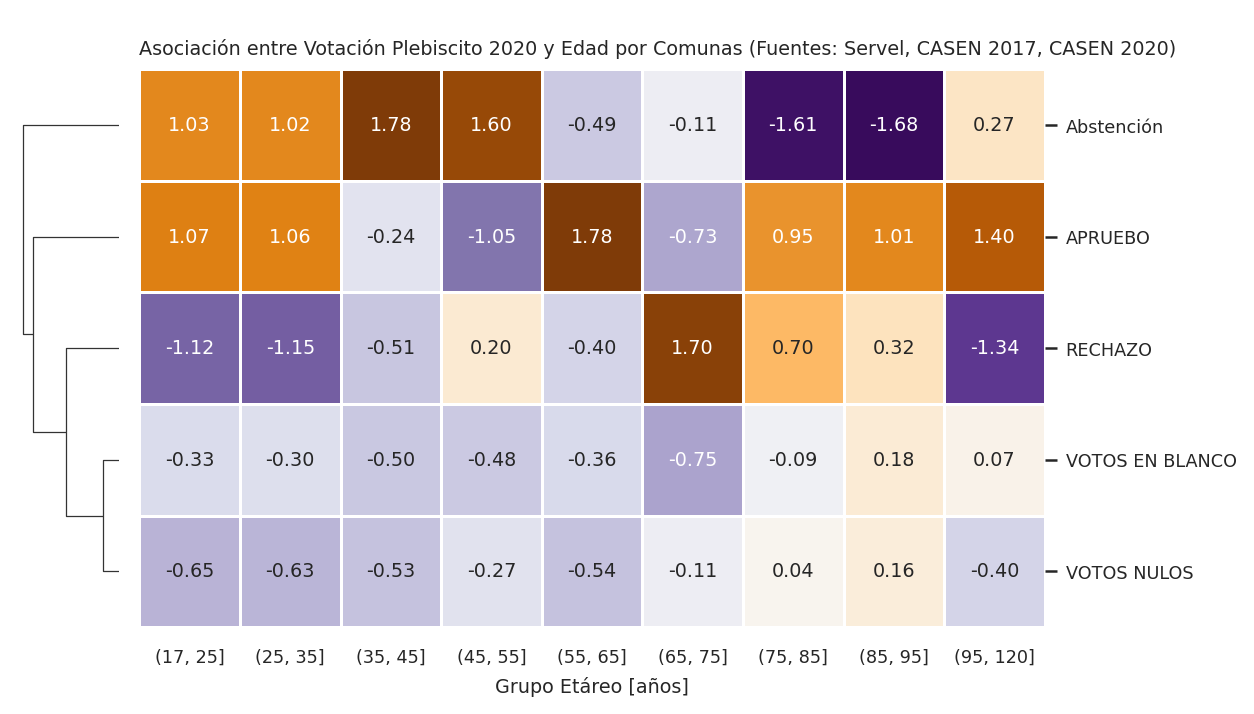

In [68]:
from aves.features.utils import standardize_columns, standardize_rows

grid = sns.clustermap(
    model.relation_profiles("constitucion", "grupo_etareo")[0][1].pipe(
        standardize_columns
    ),
    col_cluster=False,
    figsize=(7, 4),
    annot=True,
    fmt=".2f",
    linewidth=0.5,
    dendrogram_ratio=[0.1, 0.0],
    method="ward",
    center=0,
    cmap="PuOr_r",
)

grid.ax_cbar.set_visible(False)
grid.ax_heatmap

grid.ax_heatmap.set_ylabel("")
grid.ax_heatmap.set_xlabel("Grupo Etáreo [años]")
grid.ax_heatmap.set_title(
    "Asociación entre Votación Plebiscito 2020 y Edad por Comunas (Fuentes: Servel, CASEN 2017, CASEN 2020)",
    loc="left",
)

grid.fig.tight_layout()

<class 'skfusion.fusion.base.fusion_graph.ObjectType'> candidatos False (10, 12)
Relation(candidatos → comunas)
Relation(comunas → internet_inf)


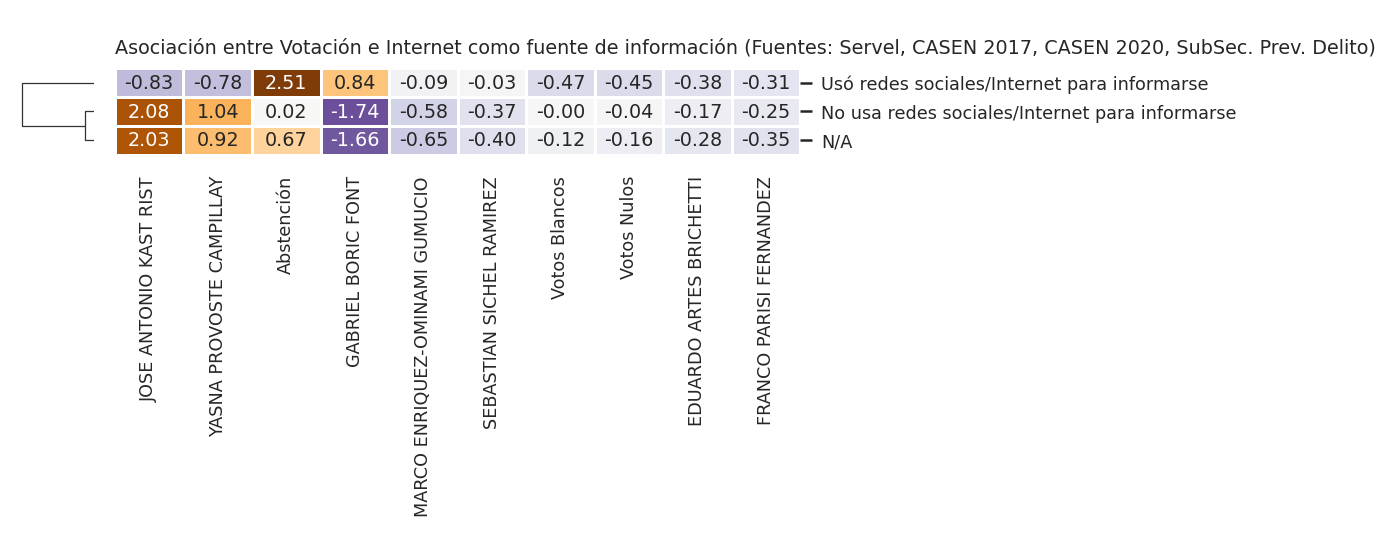

In [24]:
grid = sns.clustermap(
    model.relation_profiles("candidatos", "internet_inf")[0][1].T.pipe(
        standardize_rows
    ),
    col_cluster=True,
    figsize=(7, 3),
    annot=True,
    fmt=".2f",
    linewidth=0.5,
    dendrogram_ratio=[0.1, 0.0],
    method="ward",
    center=0,
    cmap="PuOr_r",
)

grid.ax_cbar.set_visible(False)
grid.ax_heatmap

grid.ax_heatmap.set_ylabel("")
grid.ax_heatmap.set_xlabel("")
grid.ax_heatmap.set_title(
    "Asociación entre Votación e Internet como fuente de información (Fuentes: Servel, CASEN 2017, CASEN 2020, SubSec. Prev. Delito)",
    loc="left",
)

grid.fig.tight_layout()

<class 'skfusion.fusion.base.fusion_graph.ObjectType'> constitucion False (5, 4)
Relation(constitucion → comunas)
Relation(comunas → internet_inf)


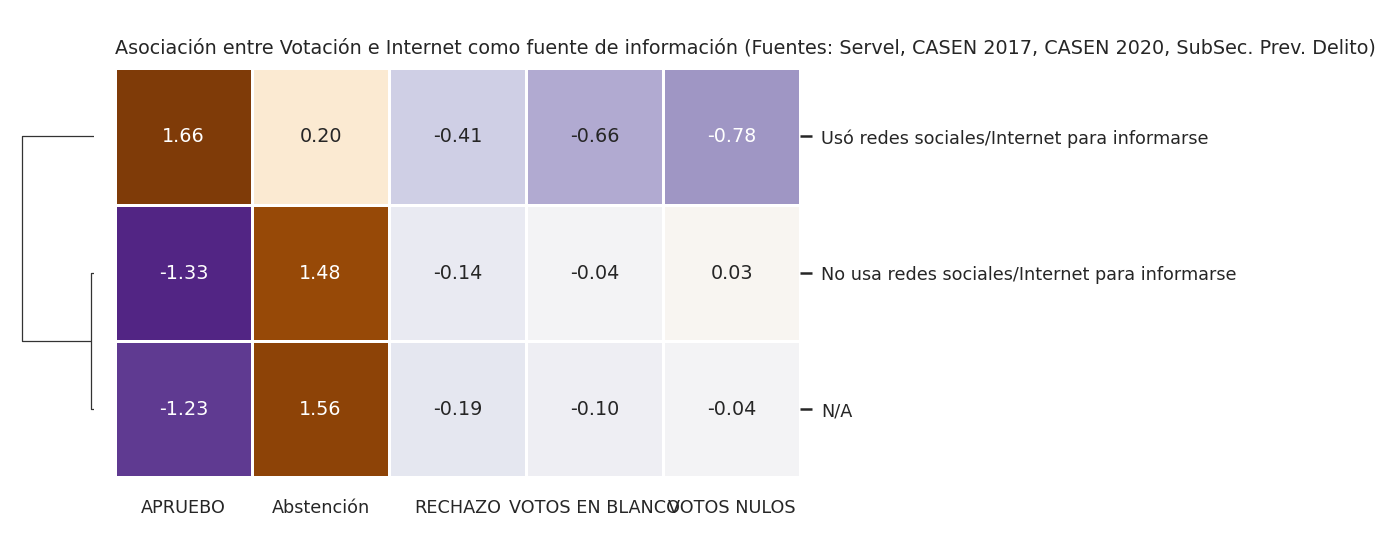

In [65]:
grid = sns.clustermap(
    model.relation_profiles("constitucion", "internet_inf")[0][1].T.pipe(
        standardize_rows
    ),
    col_cluster=True,
    figsize=(7, 3),
    annot=True,
    fmt=".2f",
    linewidth=0.5,
    dendrogram_ratio=[0.1, 0.0],
    method="ward",
    center=0,
    cmap="PuOr_r",
)

grid.ax_cbar.set_visible(False)
grid.ax_heatmap

grid.ax_heatmap.set_ylabel("")
grid.ax_heatmap.set_xlabel("")
grid.ax_heatmap.set_title(
    "Asociación entre Votación e Internet como fuente de información (Fuentes: Servel, CASEN 2017, CASEN 2020, SubSec. Prev. Delito)",
    loc="left",
)

grid.fig.tight_layout()

<class 'skfusion.fusion.base.fusion_graph.ObjectType'> candidatos False (10, 12)
Relation(candidatos → comunas)
Relation(comunas → constitucion)


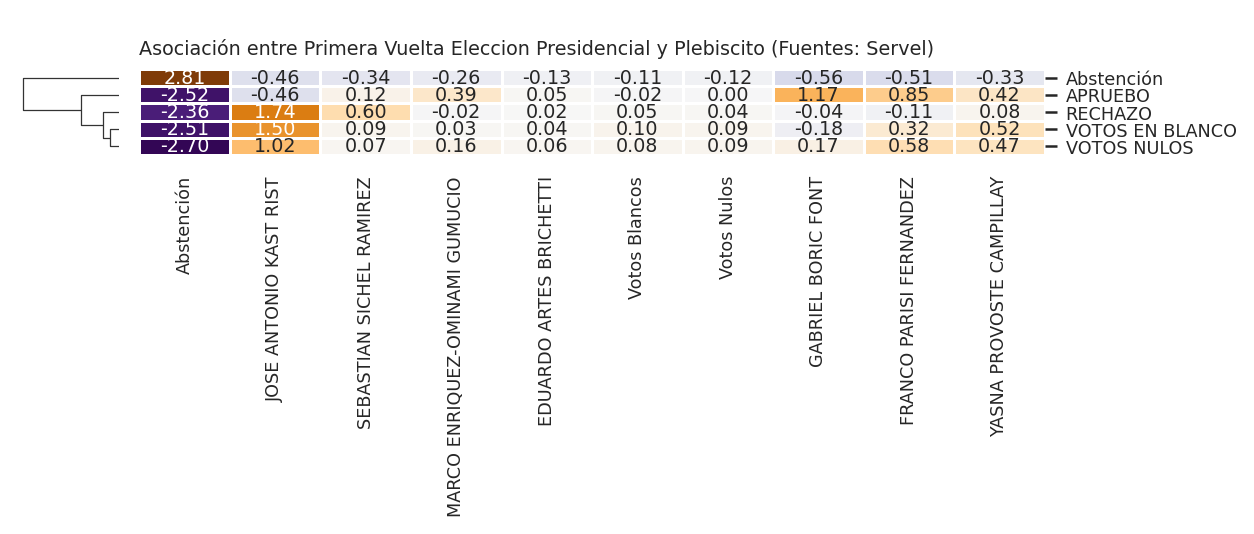

In [75]:
grid = sns.clustermap(
    model.relation_profiles("candidatos", "constitucion")[0][1].T.pipe(
        standardize_rows
    ),
    col_cluster=True,
    figsize=(7, 3),
    annot=True,
    fmt=".2f",
    linewidth=0.5,
    dendrogram_ratio=[0.1, 0.0],
    method="ward",
    center=0,
    cmap="PuOr_r",
)

grid.ax_cbar.set_visible(False)
grid.ax_heatmap

grid.ax_heatmap.set_ylabel("")
grid.ax_heatmap.set_xlabel("")
grid.ax_heatmap.set_title(
    "Asociación entre Primera Vuelta Eleccion Presidencial y Plebiscito (Fuentes: Servel)",
    loc="left",
)

grid.fig.tight_layout()